**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
  CountVectorizer + KMeans

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

SKLEARN_VERSION

'1.0.2'

## тексты

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [4]:
data.sample(2)

,text,tag
2840,"Насколько я понимаю, иск подан по статье 152 Гражданского кодекса по поводу защиты чести, достоинства и деловой репутации ведущей программы «Ревизирро» Елены Летучей. В данном случае необходимо пр...",incident
2714,"Разработкой сверхпрочных ноутбуков с защитой от воды, ударов, высоких (до +50 градусов) и низких (до -50 градусов) температур, а также электромагнитных полей займется отечественная компания ""Т-Пла...",tech


## токенизация и очистка

In [5]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [6]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

##  Vectorizer

In [11]:
%%time 

def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

X = CountVectorizer(tokenizer=tokenizer, token_pattern=None).fit_transform(data['ctext'])

## кластеризируем

In [12]:
data['cluster'] = KMeans(n_clusters=12).fit(X).labels_
data['cluster'].drop_duplicates().count()

12

## тестируем

In [13]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,0,2418,economics woman tech auto culture health sport politics reclama social incident realty science
1,1,5,woman sport social
2,2,564,economics woman tech auto culture politics social reclama realty incident sport science
3,3,157,economics woman tech auto culture politics social reclama sport incident realty science
4,4,1,woman
5,5,38,economics woman auto culture social realty sport incident
6,6,3,economics woman auto
7,7,2,woman
8,8,3,sport
9,9,2,economics reclama


<AxesSubplot:xlabel='cluster'>

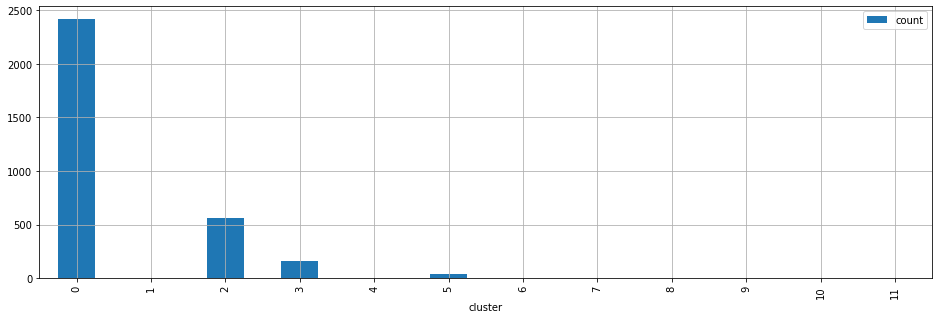

In [14]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [15]:
def print_cluster_samples(n,ns=3,nt=300):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [16]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 8, элементов: 3, метки: "sport" ]

90+6' Диего Симеоне и его команда допускают очередной "ляп" в чемпионате и тем самым усложняют себе задачу. О чемпионстве "Атлетико" говорить теперь не приходится, теперь на повестке дня стоит задача по завоеванию места в еврокубковой зоне, а сделать это с такой игрой будет весьма сложно. Возможно з ...


90+6' Отличная игра - много моментов. Очень равная игра была на поле. Хозяева комбинировали и пытались владеть мячом, а гости, в основном, контратаковали.  90+6' Матч только что завершился.  90+5' Матиас Вечино (Фиорентина) разыгрывает мяч.  90+5' Хрвое Милич (Фиорентина) обострял ситуацию сейчас. О ...


90+6' Все! Матч завершен! В сумасшедшем по накалу украинском "Эль-Класико" победу одержал "Шахтер" со счетом 4:3! Теперь "горняки" увеличили отрыв в турнирной таблице от "Динамо" на 13 очков! Предлагаем Вам выбрать лучших игроков этого матча в составах обеих команд. Для Вас прямую онлайн-трансляцию  ...


= = = = = = = = = = = = = = = = = 